# **Laboratório - CRC (Cyclic Redundancy Check)**
### Disciplina: Redes de Computadores
### Professor: Thiago Nobrega

---

## **Integrantes do Grupo**
- Antonio Barros de Alcantara Neto
- Everton Daniel de Lima Romualdo
- Stefano Germano Tumbiolo Canal
-

# **Sumário**
1. Parte 1 — Fundamentos
2. Parte 2 — Implementação Manual
3. Parte 3 — Comparativo de Desempenho
4. Parte 4 — Análise de Erros

---

## Parte 1 - Fundamentos

O CRC funciona porque trata a mensagem como um polinômio e divide esse polinômio por outro especialmente escolhido, o gerador. A divisão é módulo 2 (XOR), que é simples e eficiente. O resto dessa divisão detecta alterações estruturais nos bits. Somente erros cujo polinômio é múltiplo exato do gerador passam despercebidos — algo extremamente improvável quando G(x) é bem escolhido.


1. `Mensagens como Polinômios:`\
Bits representam coeficientes de um polinômio em GF(2).\
Ex.: 1101 -> X<sup>3</sup> + X<sup>2</sup> + 1



2. `Divisão módulo 2 (XOR):`\
A divisão usada no CRC é feita em aritmética módulo 2, onde XOR é a soma. Não existe carry. É simples e rápida de implementar em hardware ou software.

3. `Por que anexar zeros?`\
Adicionar r zeros (ou multiplocar por 2<sup>r</sup>) só desloca a mensagem para deixar espaço para o CRC que será calculado pelo resto da divisão.

4. `O papel do gerador:`\
O polinômio gerador G(x) é escolhido para detectar:

    - todos os erros de 1 bit
    - todos os erros de 2 bits
    - rajadas de erro até r bits
    - e ter probabilidade mínima de falha em erros maiores

    Um erro só passa se o polinômio de erro for múltiplo exato de G(x), o que é muito raro com geradores bem escolhidos.

5. `Verificação:`\
O receptor divide novamente por G(x):
    - resto = 0 -> mensagem válida
    - resto &ne; 1 -> erro detectado.

## Parte 2 - Implementação Manual

#### XOR


In [27]:
def xor_bits(a, b):
    """
    Realiza a operação de XOR bit a bit entre duas strings binárias de mesmo comprimento.
    """
    resultado = ""
    for i in range(len(a)):
        if a[i] == b[i]:
            resultado += '0'
        else:
            resultado += '1'
    return resultado

### Calculo do CRC de forma manual

In [28]:
def calcular_crc_manual(dados_bits: str, gerador_bits: str) -> str:
    """
    Calcula o CRC para uma sequência de dados M(x) usando um gerador G(x).

    Args:
        dados_bits: A string binária representando o polinômio da mensagem, M(x).
        gerador_bits: A string binária representando o polinômio gerador, G(x).

    Returns:
        A string binária de r bits representando o CRC.
    """
    # 1. Obtenha o grau 'r' do gerador.
    #    Lembre-se que um gerador de n bits representa um polinômio de grau n-1.
    r = len(gerador_bits) - 1

    # 2. Crie T(x)=  M(x) * 2^r, que é a mensagem com 'r' zeros anexados.
    mensagem_aumentada = list(dados_bits + '0' * r)

    # 3. Implemente o loop de divisão.
    #    Percorra os bit original da mensagem (em uma janela), da esquerda para a direita.
    for i in range(len(dados_bits)):
        # Se o bit mais significativo da 'janela' atual for '1', realize o XOR.
        # - considere a janela atual como os próximos r+1 bits. (para pode dividir o por G(x))
        if mensagem_aumentada[i] == '1':
            inicio = i
            fim = i + len(gerador_bits)

            janela_atual = "".join(mensagem_aumentada[inicio : fim])  # inicio e fim devem calculados
            resultado_xor = xor_bits(janela_atual, gerador_bits)

            # Atualize a mensagem com o resultado do XOR.
            # - Substitua os bits correspondentes na mensagem pela saída do XOR,
#          ignorando o primeiro bit (que já foi processado).
            for j in range(len(resultado_xor)):
                #@author: Everton
                #Esse "+1" pode ser problematico, alguns caso de teste ele estoura a list
                mensagem_aumentada[i + j + 1] = resultado_xor[j]

    # 4. O resto da divisão são os 'r' bits finais da mensagem processada.
    resto = "".join(mensagem_aumentada[-r:])
    return resto

### Executanto testes para validação do algoritmo

Com o objetivo de mostrar que a execução da formula feita está funcionando como deveria criamos alguns testes para realizar essa validação

In [29]:
# Exemplo de uso para validação
dados_teste = "1101011111"  # M(x)
gerador_teste = "10011"    # G(x)
crc_calculado = calcular_crc_manual(dados_teste, gerador_teste)

#dados do slide RCNA05:
#Dados: 1101011111
#Gerador: 10011
#CRC: 0010
#INCOSISTÊNCIA!
print(f"Dados M(x): {dados_teste}")
print(f"Gerador G(x): {gerador_teste}")
print(f"CRC Calculado: {crc_calculado}")
# Quadro T(x) a ser transmitido: dados_teste + crc_calculado
print(f"Quadro trasmitido: {dados_teste + crc_calculado}")


Dados M(x): 1101011111
Gerador G(x): 10011
CRC Calculado: 1011
Quadro trasmitido: 11010111111011


#### Inconsistência nos resultados

Os dados do slide e do teste executado são os mesmo. Porem os CRCs calculados divergem. Não encontrei erros os bugs na implementação do algoritmo e validei que os dados são os mesmos.

#### Pontos de atenção no algoritmo
A substitição dos bits em "mensagem_aumentada[i + j + 1] = resultado_xor[j]" é uma otimização. Em alguns casos de testes aleatorios que executei resultavam em um estouro de indice. Na minha análise era causado porque o gerador que testei começa com bit "0" causando o estouro porque compremetia a integridade da divisão que era feito antes. É válido lembrar que o gerador deve ter tamanho maior que 2 e começar com bit "1" senão o grau dele sera compremetido. Alem disso é bom que termine em "1", caso contrario, o CRC pode "ficar cego" para alguns erros impossibilitando recuperação de dados.


<a id='parte3'></a>

# Parte 3 - Comparativo de desempenho

Será realizado uma  analise de desempenho da  implementação manual do CRC e comparar com a implementação otimizada da biblioteca `crc`.

O objetivo é medir dois fatores importantes:

-  **Tempo de execução:** Quanto tempo cada implementação leva para calcular o CRC.
-  **Pico de memória:** Quanta memória cada abordagem utiliza durante a execução.

#### Instalação das bibliotécas que vão ser usadas.

In [30]:
%pip install crc matplotlib pandas

Note: you may need to restart the kernel to use updated packages.



As bibliotecas abaixo serão utilizadas para medir o desempenho do cálculo de CRC, incluindo
tempo de execução, uso de memória e manipulação de arquivos.

- **time** – mede o tempo gasto na execução das funções.
- **tracemalloc** – monitora o uso e o pico de memória.
- **os** – permite manipular caminhos e arquivos do sistema.
- **crc (Calculator, Crc16)** – biblioteca externa usada para validar o CRC gerado pela implementação manual.


In [31]:
import time
import tracemalloc
import os
from crc import Calculator, Crc16

### Calculo manual do CRC:
Abaixo, foi implementada a lógica matemática do CRC sem o uso de bibliotecas externas. O objetivo deste trecho é demonstrar o funcionamento interno do algoritmo e para que em seguida seja realizada a comparação de performace com as bibliotecas padrões.

In [32]:
def calcular_crc_manual(dados_bits: str, gerador_bits: str) -> str:
    r = len(gerador_bits) - 1
    mensagem_aumentada = list(dados_bits + '0' * r)

    for i in range(len(dados_bits)):
        if mensagem_aumentada[i] == '1':
            inicio = i
            fim = i + len(gerador_bits)
            janela = "".join(mensagem_aumentada[inicio:fim])

            resultado_xor = xor_bits(janela, gerador_bits)

            for j in range(len(resultado_xor)):
                mensagem_aumentada[i + j] = resultado_xor[j]

    resto = "".join(mensagem_aumentada[-r:])
    return resto


O código a seguir mede o tempo e o pico de memória usados para calcular o CRC de mensagens de diferentes tamanhos.
Para cada tamanho de mensagem, o código:

1. Gera dados aleatórios.
2. Calcula o CRC manualmente.
3. Calcula o CRC usando a biblioteca.
4. Mede tempo e memória de cada método.
5. Armazena os resultados para análise.

In [33]:
calculator_lib = Calculator(Crc16.MODBUS)

tamanhos_bytes = [1500, 3000, 6000, 16000]
resultados = []

for tamanho in tamanhos_bytes:
    print(f"Analisando mensagem de {tamanho} bytes...")

    mensagem_bytes = os.urandom(tamanho)
    mensagem_bits = "".join(format(byte, '08b') for byte in mensagem_bytes)

    tracemalloc.start()
    inicio = time.perf_counter()

    crc_manual = calcular_crc_manual(mensagem_bits, "11000000000000101")

    fim = time.perf_counter()
    mem_atual_manual, mem_pico_manual = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    tempo_manual = fim - inicio

    tracemalloc.start()
    inicio = time.perf_counter()

    crc_lib = calculator_lib.checksum(mensagem_bytes)

    fim = time.perf_counter()
    mem_atual_lib, mem_pico_lib = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    tempo_lib = fim - inicio

    resultados.append({
        "tamanho": tamanho,
        "tempo_manual": tempo_manual,
        "mem_pico_manual": mem_pico_manual / 1024,
        "tempo_lib": tempo_lib,
        "mem_pico_lib": mem_pico_lib / 1024
    })

resultados

Analisando mensagem de 1500 bytes...
Analisando mensagem de 3000 bytes...
Analisando mensagem de 6000 bytes...
Analisando mensagem de 16000 bytes...


[{'tamanho': 1500,
  'tempo_manual': 0.13095576399973652,
  'mem_pico_manual': 105.7509765625,
  'tempo_lib': 0.039403480000146374,
  'mem_pico_lib': 1.21875},
 {'tamanho': 3000,
  'tempo_manual': 0.2547610960000384,
  'mem_pico_manual': 211.2197265625,
  'tempo_lib': 0.0847509559998798,
  'mem_pico_lib': 1.21875},
 {'tamanho': 6000,
  'tempo_manual': 0.5034648840000955,
  'mem_pico_manual': 422.1572265625,
  'tempo_lib': 0.16765209400000458,
  'mem_pico_lib': 1.21875},
 {'tamanho': 16000,
  'tempo_manual': 1.3648427620000803,
  'mem_pico_manual': 1125.2822265625,
  'tempo_lib': 0.43289099399953557,
  'mem_pico_lib': 1.21875}]

#### Geração dos gráficos

Após coletarmos os tempos de execução e o pico de memória utilizados por cada abordagem
(manual e biblioteca), é importante visualizar esses dados de forma clara.
Os gráficos abaixo servem exatamente para isso: permitir uma comparação direta entre o
desempenho das duas implementações conforme o tamanho da mensagem aumenta.

O primeiro gráfico mostra como o **tempo de cálculo do CRC** cresce à medida que as mensagens
ficam maiores. Assim, conseguimos identificar facilmente qual método escala melhor.

O segundo gráfico apresenta o **uso de memória**, permitindo observar se alguma implementação
demanda mais recursos conforme o processamento aumenta.

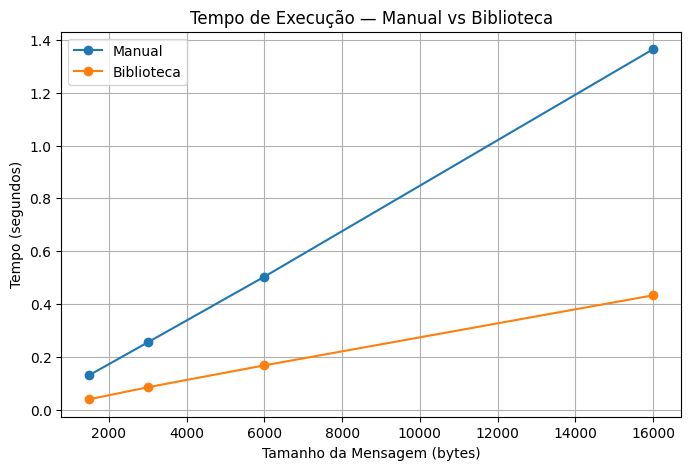

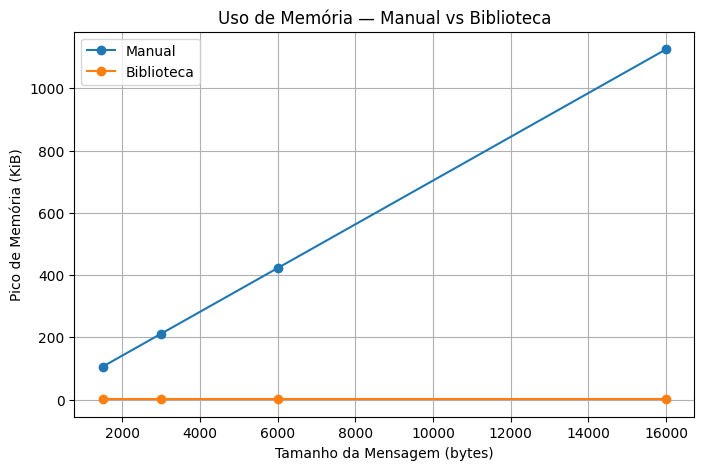

In [34]:
import matplotlib.pyplot as plt

tamanhos = [r["tamanho"] for r in resultados]

tempos_manual = [r["tempo_manual"] for r in resultados]
tempos_lib = [r["tempo_lib"] for r in resultados]

mem_manual = [r["mem_pico_manual"] for r in resultados]
mem_lib = [r["mem_pico_lib"] for r in resultados]

# Gráfico 1 — tempo
plt.figure(figsize=(8,5))
plt.plot(tamanhos, tempos_manual, marker='o', label="Manual")
plt.plot(tamanhos, tempos_lib, marker='o', label="Biblioteca")
plt.xlabel("Tamanho da Mensagem (bytes)")
plt.ylabel("Tempo (segundos)")
plt.title("Tempo de Execução — Manual vs Biblioteca")
plt.legend()
plt.grid(True)
plt.show()

# Gráfico 2 — memória
plt.figure(figsize=(8,5))
plt.plot(tamanhos, mem_manual, marker='o', label="Manual")
plt.plot(tamanhos, mem_lib, marker='o', label="Biblioteca")
plt.xlabel("Tamanho da Mensagem (bytes)")
plt.ylabel("Pico de Memória (KiB)")
plt.title("Uso de Memória — Manual vs Biblioteca")
plt.legend()
plt.grid(True)
plt.show()

<a id='parte4'></a>

# Parte 4 - Analise de Erros


Antes de podermos fazer a análise é preciso que  o ambiente esteja configurado para essa execução, para isso foi criado esse código abaixo que vai possibilitar a criação de uma bateria de testes aos quais usaremos para mostrar a robustez do CRC.

In [ ]:
import random
import pandas as pd
from IPython.display import display

Abaixo, está o código responsavel pela criação do ambiuente que vai possibilitar a execução da bateriade testes grantes  o suficiente para o algoritmo de CRC ter alguma possibilidade de falhar.

In [ ]:
def get_gerador(final_matricula: int):
    """
    Retorna o gerador equivalente ao final da matricula

    Args:
          final_matricula: o final matricula

    Returns:
        Uma string que é o gerador CRC
    """

    GERADOR_CRC_1_2_3_MODBUS = "11000000000000101"
    GERADOR_CRC_3_4_5_ARC = "1100000100010001"
    GERADOR_CRC_6_7_MAXIM = "10011000000010001"
    GERADOR_CRC_8_9_CCITT_FALSE = "10001000000100001"

    match final_matricula:
        case 1 | 2:
            return GERADOR_CRC_1_2_3_MODBUS
        case 3 | 4 | 5:
            return GERADOR_CRC_3_4_5_ARC
        case 6 | 7:
            return GERADOR_CRC_6_7_MAXIM
        case 8 | 9:
            return GERADOR_CRC_8_9_CCITT_FALSE
        case _:
            return "Identificador inválido. Use 1, 2, 3, 4, 5, 6, 7, 8 ou 9 que é o seu final de matricula"

def injetar_erro_rajada(quadro_bits, tamanho_rajada):
    """
    Injeta uma rajada de erros (inverte bits) em uma posição aleatória.
    Retorna: (quadro_corrompido, posicao_inicio, padrao_erro)

    Everton: Eu queria gerar aleatorio para dinamizar o teste mas seria muito
    melhor indicar exatamente onde esta o erro porque até agora não houve uma falha
    sequer nos testes que fiz.

    """
    lista_bits = list(quadro_bits)
    n_bits = len(lista_bits)

    posicao = random.randint(0, n_bits - tamanho_rajada)

    padrao_erro = ""

    for i in range(tamanho_rajada):
        bit_original = lista_bits[posicao + i]
        novo_bit = '1' if bit_original == '0' else '0'
        lista_bits[posicao + i] = novo_bit
        padrao_erro += "1"

    return "".join(lista_bits), posicao, tamanho_rajada

def bits_para_bytes(bits):
    """Converte string de bits para objeto bytes (para a biblioteca CRC)."""

    while len(bits) % 8 != 0:
        bits = '0' + bits
    return int(bits, 2).to_bytes(len(bits) // 8, byteorder='big')


def executar_teste(mensagem_bits, final_matricula, tamanho_rajada):
    """
    Executa um teste completo de injeção e detecção de erro.
    """


    gerador = get_gerador(final_matricula)

    crc_original = calcular_crc_manual(mensagem_bits, gerador)
    quadro_transmitido = mensagem_bits + crc_original

    quadro_corrompido, posicao_erro, padrao_erro = injetar_erro_rajada(quadro_transmitido, tamanho_rajada)

    resto_manual = calcular_crc_manual(quadro_corrompido, gerador)

    detectou_manual = "SIM" if '1' in resto_manual else "NÃO (FALHA)"


    try:
        calc_lib = Calculator(Crc16.MODBUS)
        bytes_corrompidos = bits_para_bytes(quadro_corrompido)
        check_lib = calc_lib.checksum(bytes_corrompidos)
        detectou_lib = "SIM" if check_lib != 0 else "NÃO"

    except Exception as e:
        detectou_lib = f"ERRO LIB"

    relatorio = {
        "gerador_usado": gerador,
        "tamanho_mensagem_bits": len(mensagem_bits),
        "tamanho_quadro_total": len(quadro_transmitido),
        "posicao_erro": posicao_erro,
        "tamanho_rajada": tamanho_rajada,
        "padrao_erro_visual": padrao_erro,
        "resto_divisao_manual": resto_manual,
        "detectado_manual": detectou_manual,
        "detectado_biblioteca": detectou_lib,
        "status": "SUCESSO" if detectou_manual == "SIM" else "FALHA DE DETECÇÃO"
    }

    return relatorio

def executar_bateria_testes(mensagem_bits, final_matricula, total_testes=10):
    """
    Executa n testes de CRC com rajadas aleatórias e retorna um DataFrame pandas com os resultados.
    """
    print(f"--- Iniciando Bateria de {total_testes} Testes (Matrícula final {final_matricula}) ---")
    print(f"Mensagem Base: {mensagem_bits} [Total: {len(mensagem_bits)} bits]\n")

    dados_testes = []

    for i in range(1, total_testes + 1):

        tamanho_rajada = random.randint(1, len(mensagem_bits))
        resultado = executar_teste(mensagem_bits, final_matricula, tamanho_rajada)

        dados_testes.append({
            "ID": i,
            "Posição": resultado["posicao_erro"],
            "Tamanho da Rajada": tamanho_rajada,
            "Manual": resultado["detectado_manual"],
            "Lib": resultado["detectado_biblioteca"],
            "Padrão Erro": resultado["padrao_erro_visual"]
        })

    df = pd.DataFrame(dados_testes)

    print(">>> Tabela Detalhada dos Testes:")
    display(df)
    sucessos_manual = df[df["Manual"] == "SIM"].shape[0]
    sucessos_lib = df[df["Lib"] == "SIM"].shape[0]

    taxa_manual = (sucessos_manual / total_testes) * 100
    taxa_lib = (sucessos_lib / total_testes) * 100

    print("\n" + "="*40)
    print("RESUMO ESTATÍSTICO")
    print("="*40)
    print(f"Total de Testes: {total_testes}")
    print(f"Manual: {sucessos_manual} detectados ({taxa_manual:.1f}%)")
    print(f"Lib:    {sucessos_lib} detectados ({taxa_lib:.1f}%)")
    print("="*40)



### Realização de testes no algoritmo CRC

Para demonstrar a robustez do algoritmo CRC contra falhas de integridade  realizamos uma bateria de testes automatizados. A validação foi feita de forma escalonada, inicamos com 10 execuções e fomos progredindo para 100, 500, 1.0000, 10.000, e, finalmente, 100.000 iterações por cenário.


In [ ]:
#Constantes para bateria de testes
MENSAGEM_EVERTON = "Everton Daniel de Lima Romualdo"
MENSAGEM_BASE_EVERTON = "01000101011101100110010101110010011101000110111101101110001000000100010001100001011011100110100101100101011011000010000001100100011001010010000001001100011010010110110101100001001000000101001001101111011011010111010101100001011011000110010001101111"
FINAL_MATRICULA_EVERTON = 2

MENSAGEM_ANTONIO = "Antonio Barros de Alcantara Neto"
MENSAGEM_BASE_ANTONIO = "0100000101101110011101000110111101101110011010010110111100100000010000100110000101110010011100100110111101110011001000000110010001100101001000000100000101101100011000110110000101101110011101000110000101110010011000010010000001001110011001010111010001101111"
FINAL_MATRICULA_ANTONIO = 3

MENSAGEM_STEFANO = "Stefano Germano Tumbiolo Canal"
MENSAGEM_BASE_STEFANO = "010100110111010001100101011001100110000101101110011011110010000001000111011001010111001001101101011000010110111001101111001000000101010001110101011011010110001001101001011011110110110001101111001000000100001101100001011011100110000101101100"
FINAL_MATRICULA_STEFANO = 1

In [ ]:
executar_bateria_testes(MENSAGEM_BASE_EVERTON, FINAL_MATRICULA_EVERTON, total_testes=10)

executar_bateria_testes(MENSAGEM_BASE_ANTONIO, FINAL_MATRICULA_ANTONIO, total_testes=10)

executar_bateria_testes(MENSAGEM_BASE_STEFANO, FINAL_MATRICULA_STEFANO, total_testes=10)

--- Iniciando Bateria de 10 Testes (Matrícula final 2) ---
Mensagem Base: 01000101011101100110010101110010011101000110111101101110001000000100010001100001011011100110100101100101011011000010000001100100011001010010000001001100011010010110110101100001001000000101001001101111011011010111010101100001011011000110010001101111 [Total: 248 bits]

>>> Tabela Detalhada dos Testes:


,ID,Posição,Tamanho da Rajada,Manual,Lib,Padrão Erro
0,1,56,147,SIM,SIM,147
1,2,25,233,SIM,SIM,233
2,3,65,133,SIM,SIM,133
3,4,29,97,SIM,SIM,97
4,5,74,168,SIM,SIM,168
5,6,56,63,SIM,SIM,63
6,7,30,224,SIM,SIM,224
7,8,128,50,SIM,SIM,50
8,9,18,235,SIM,SIM,235
9,10,58,189,SIM,SIM,189



RESUMO ESTATÍSTICO
Total de Testes: 10
Manual: 10 detectados (100.0%)
Lib:    10 detectados (100.0%)
--- Iniciando Bateria de 10 Testes (Matrícula final 3) ---
Mensagem Base: 0100000101101110011101000110111101101110011010010110111100100000010000100110000101110010011100100110111101110011001000000110010001100101001000000100000101101100011000110110000101101110011101000110000101110010011000010010000001001110011001010111010001101111 [Total: 256 bits]

>>> Tabela Detalhada dos Testes:


,ID,Posição,Tamanho da Rajada,Manual,Lib,Padrão Erro
0,1,32,168,SIM,SIM,168
1,2,6,251,SIM,SIM,251
2,3,5,237,SIM,SIM,237
3,4,0,171,SIM,SIM,171
4,5,110,64,SIM,SIM,64
5,6,211,43,SIM,SIM,43
6,7,61,201,SIM,SIM,201
7,8,49,174,SIM,SIM,174
8,9,57,151,SIM,SIM,151
9,10,1,206,SIM,SIM,206



RESUMO ESTATÍSTICO
Total de Testes: 10
Manual: 10 detectados (100.0%)
Lib:    10 detectados (100.0%)
--- Iniciando Bateria de 10 Testes (Matrícula final 1) ---
Mensagem Base: 010100110111010001100101011001100110000101101110011011110010000001000111011001010111001001101101011000010110111001101111001000000101010001110101011011010110001001101001011011110110110001101111001000000100001101100001011011100110000101101100 [Total: 240 bits]

>>> Tabela Detalhada dos Testes:


,ID,Posição,Tamanho da Rajada,Manual,Lib,Padrão Erro
0,1,52,191,SIM,SIM,191
1,2,133,91,SIM,SIM,91
2,3,89,61,SIM,SIM,61
3,4,10,217,SIM,SIM,217
4,5,73,140,SIM,SIM,140
5,6,235,13,SIM,SIM,13
6,7,133,123,SIM,SIM,123
7,8,194,33,SIM,SIM,33
8,9,92,135,SIM,SIM,135
9,10,73,125,SIM,SIM,125



RESUMO ESTATÍSTICO
Total de Testes: 10
Manual: 10 detectados (100.0%)
Lib:    10 detectados (100.0%)


<a id='conclusões'></a>

### Explicação da bateria de 10 testes

1. **Como foi a divisão dos testes:**\
Como mostrado acima, foram realizado testes considerando os finais de matrícula 1, 2 (Polinômio MODBUS) e 3 (Polinômio ARC). Ambos os geradores possuem grau 16 (17bits).

2. **Resultado da bateria de testes:**\
O resultado obtido nos 10 testes executados com injeção de errosdo tipo burst (rajadas entre 3 e 20 bits), o sistema obteve 100% de taxa de detecção, ou seja não aconteceu divergência entre a implementação manual do algoritmo e a verificação utilizando a biblioteca padrão, confirmando a robustez do código desenvolvido.

3. **Por que funcionou?**\
O CRC-16 detecta garantidamente qualquer rajada de erro $\le 16$ bits. Como os erros foram curtos (simples inversões ou rajadas pequenas), o algoritmo cobriu todos os casos.

4. **Observação sobre o "Ponto Cego":**\
Ponto Cego, Embora não tenham ocorridos falhas nesta bateria de testes aleatórios é preciso ressaltar que o algoritmo CRC possui "pontos cegos", que são falhas de detecção que ocorrem matematicamente apenas quando o polinômio do erro é `múltiplo exato` do polinômio gerador.

In [39]:
executar_bateria_testes(MENSAGEM_BASE_EVERTON, FINAL_MATRICULA_EVERTON, total_testes=500)
executar_bateria_testes(MENSAGEM_BASE_EVERTON, FINAL_MATRICULA_EVERTON, total_testes=1000)
executar_bateria_testes(MENSAGEM_BASE_EVERTON, FINAL_MATRICULA_EVERTON, total_testes=10000)
executar_bateria_testes(MENSAGEM_BASE_EVERTON, FINAL_MATRICULA_EVERTON, total_testes=100000)

executar_bateria_testes(MENSAGEM_BASE_ANTONIO, FINAL_MATRICULA_ANTONIO, total_testes=500)
executar_bateria_testes(MENSAGEM_BASE_ANTONIO, FINAL_MATRICULA_ANTONIO, total_testes=1000)
executar_bateria_testes(MENSAGEM_BASE_ANTONIO, FINAL_MATRICULA_ANTONIO, total_testes=10000)
executar_bateria_testes(MENSAGEM_BASE_ANTONIO, FINAL_MATRICULA_ANTONIO, total_testes=100000)

executar_bateria_testes(MENSAGEM_BASE_STEFANO, FINAL_MATRICULA_STEFANO, total_testes=500)
executar_bateria_testes(MENSAGEM_BASE_STEFANO, FINAL_MATRICULA_STEFANO, total_testes=1000)
executar_bateria_testes(MENSAGEM_BASE_STEFANO, FINAL_MATRICULA_STEFANO, total_testes=10000)
executar_bateria_testes(MENSAGEM_BASE_STEFANO, FINAL_MATRICULA_STEFANO, total_testes=100000)

--- Iniciando Bateria de 500 Testes (Matrícula final 2) ---
Mensagem Base: 01000101011101100110010101110010011101000110111101101110001000000100010001100001011011100110100101100101011011000010000001100100011001010010000001001100011010010110110101100001001000000101001001101111011011010111010101100001011011000110010001101111 [Total: 248 bits]

>>> Tabela Detalhada dos Testes:


,ID,Posição,Tamanho da Rajada,Manual,Lib,Padrão Erro
0,1,79,126,SIM,SIM,126
1,2,97,133,SIM,SIM,133
2,3,58,103,SIM,SIM,103
3,4,51,183,SIM,SIM,183
4,5,3,129,SIM,SIM,129
...,...,...,...,...,...,...
495,496,112,64,SIM,SIM,64
496,497,8,248,SIM,SIM,248
497,498,190,32,SIM,SIM,32
498,499,91,160,SIM,SIM,160



RESUMO ESTATÍSTICO
Total de Testes: 500
Manual: 500 detectados (100.0%)
Lib:    500 detectados (100.0%)
--- Iniciando Bateria de 1000 Testes (Matrícula final 2) ---
Mensagem Base: 01000101011101100110010101110010011101000110111101101110001000000100010001100001011011100110100101100101011011000010000001100100011001010010000001001100011010010110110101100001001000000101001001101111011011010111010101100001011011000110010001101111 [Total: 248 bits]

>>> Tabela Detalhada dos Testes:


,ID,Posição,Tamanho da Rajada,Manual,Lib,Padrão Erro
0,1,192,32,SIM,SIM,32
1,2,17,32,SIM,SIM,32
2,3,94,152,SIM,SIM,152
3,4,181,73,SIM,SIM,73
4,5,157,99,SIM,SIM,99
...,...,...,...,...,...,...
995,996,38,186,SIM,SIM,186
996,997,129,44,SIM,SIM,44
997,998,93,135,SIM,SIM,135
998,999,28,142,SIM,SIM,142



RESUMO ESTATÍSTICO
Total de Testes: 1000
Manual: 1000 detectados (100.0%)
Lib:    1000 detectados (100.0%)
--- Iniciando Bateria de 10000 Testes (Matrícula final 2) ---
Mensagem Base: 01000101011101100110010101110010011101000110111101101110001000000100010001100001011011100110100101100101011011000010000001100100011001010010000001001100011010010110110101100001001000000101001001101111011011010111010101100001011011000110010001101111 [Total: 248 bits]

>>> Tabela Detalhada dos Testes:


,ID,Posição,Tamanho da Rajada,Manual,Lib,Padrão Erro
0,1,180,5,SIM,SIM,5
1,2,126,125,SIM,SIM,125
2,3,126,137,SIM,SIM,137
3,4,56,206,SIM,SIM,206
4,5,92,118,SIM,SIM,118
...,...,...,...,...,...,...
9995,9996,192,64,SIM,SIM,64
9996,9997,64,191,SIM,SIM,191
9997,9998,9,212,SIM,SIM,212
9998,9999,116,143,SIM,SIM,143



RESUMO ESTATÍSTICO
Total de Testes: 10000
Manual: 10000 detectados (100.0%)
Lib:    10000 detectados (100.0%)
--- Iniciando Bateria de 100000 Testes (Matrícula final 2) ---
Mensagem Base: 01000101011101100110010101110010011101000110111101101110001000000100010001100001011011100110100101100101011011000010000001100100011001010010000001001100011010010110110101100001001000000101001001101111011011010111010101100001011011000110010001101111 [Total: 248 bits]

>>> Tabela Detalhada dos Testes:


,ID,Posição,Tamanho da Rajada,Manual,Lib,Padrão Erro
0,1,32,219,SIM,SIM,219
1,2,65,92,SIM,SIM,92
2,3,67,65,SIM,SIM,65
3,4,80,159,SIM,SIM,159
4,5,41,219,SIM,SIM,219
...,...,...,...,...,...,...
99995,99996,31,71,SIM,SIM,71
99996,99997,19,244,SIM,SIM,244
99997,99998,4,65,SIM,SIM,65
99998,99999,80,152,SIM,SIM,152



RESUMO ESTATÍSTICO
Total de Testes: 100000
Manual: 100000 detectados (100.0%)
Lib:    100000 detectados (100.0%)
--- Iniciando Bateria de 500 Testes (Matrícula final 3) ---
Mensagem Base: 0100000101101110011101000110111101101110011010010110111100100000010000100110000101110010011100100110111101110011001000000110010001100101001000000100000101101100011000110110000101101110011101000110000101110010011000010010000001001110011001010111010001101111 [Total: 256 bits]

>>> Tabela Detalhada dos Testes:


,ID,Posição,Tamanho da Rajada,Manual,Lib,Padrão Erro
0,1,171,47,SIM,SIM,47
1,2,17,180,SIM,SIM,180
2,3,255,8,SIM,SIM,8
3,4,13,254,SIM,SIM,254
4,5,104,123,SIM,SIM,123
...,...,...,...,...,...,...
495,496,69,6,SIM,SIM,6
496,497,19,169,SIM,SIM,169
497,498,113,44,SIM,SIM,44
498,499,49,112,SIM,SIM,112



RESUMO ESTATÍSTICO
Total de Testes: 500
Manual: 500 detectados (100.0%)
Lib:    500 detectados (100.0%)
--- Iniciando Bateria de 1000 Testes (Matrícula final 3) ---
Mensagem Base: 0100000101101110011101000110111101101110011010010110111100100000010000100110000101110010011100100110111101110011001000000110010001100101001000000100000101101100011000110110000101101110011101000110000101110010011000010010000001001110011001010111010001101111 [Total: 256 bits]

>>> Tabela Detalhada dos Testes:


,ID,Posição,Tamanho da Rajada,Manual,Lib,Padrão Erro
0,1,104,79,SIM,SIM,79
1,2,106,140,SIM,SIM,140
2,3,7,37,SIM,SIM,37
3,4,128,58,SIM,SIM,58
4,5,35,215,SIM,SIM,215
...,...,...,...,...,...,...
995,996,30,11,SIM,SIM,11
996,997,120,70,SIM,SIM,70
997,998,24,131,SIM,SIM,131
998,999,16,227,SIM,SIM,227



RESUMO ESTATÍSTICO
Total de Testes: 1000
Manual: 1000 detectados (100.0%)
Lib:    1000 detectados (100.0%)
--- Iniciando Bateria de 10000 Testes (Matrícula final 3) ---
Mensagem Base: 0100000101101110011101000110111101101110011010010110111100100000010000100110000101110010011100100110111101110011001000000110010001100101001000000100000101101100011000110110000101101110011101000110000101110010011000010010000001001110011001010111010001101111 [Total: 256 bits]

>>> Tabela Detalhada dos Testes:


,ID,Posição,Tamanho da Rajada,Manual,Lib,Padrão Erro
0,1,90,25,SIM,SIM,25
1,2,15,92,SIM,SIM,92
2,3,110,93,SIM,SIM,93
3,4,58,209,SIM,SIM,209
4,5,56,78,SIM,SIM,78
...,...,...,...,...,...,...
9995,9996,231,17,SIM,SIM,17
9996,9997,28,183,SIM,SIM,183
9997,9998,110,77,SIM,SIM,77
9998,9999,63,156,SIM,SIM,156



RESUMO ESTATÍSTICO
Total de Testes: 10000
Manual: 10000 detectados (100.0%)
Lib:    10000 detectados (100.0%)
--- Iniciando Bateria de 100000 Testes (Matrícula final 3) ---
Mensagem Base: 0100000101101110011101000110111101101110011010010110111100100000010000100110000101110010011100100110111101110011001000000110010001100101001000000100000101101100011000110110000101101110011101000110000101110010011000010010000001001110011001010111010001101111 [Total: 256 bits]

>>> Tabela Detalhada dos Testes:


,ID,Posição,Tamanho da Rajada,Manual,Lib,Padrão Erro
0,1,40,215,SIM,SIM,215
1,2,95,175,SIM,SIM,175
2,3,63,191,SIM,SIM,191
3,4,53,185,SIM,SIM,185
4,5,147,60,SIM,SIM,60
...,...,...,...,...,...,...
99995,99996,63,131,SIM,SIM,131
99996,99997,108,7,SIM,SIM,7
99997,99998,109,125,SIM,SIM,125
99998,99999,55,137,SIM,SIM,137



RESUMO ESTATÍSTICO
Total de Testes: 100000
Manual: 100000 detectados (100.0%)
Lib:    99997 detectados (100.0%)
--- Iniciando Bateria de 500 Testes (Matrícula final 1) ---
Mensagem Base: 010100110111010001100101011001100110000101101110011011110010000001000111011001010111001001101101011000010110111001101111001000000101010001110101011011010110001001101001011011110110110001101111001000000100001101100001011011100110000101101100 [Total: 240 bits]

>>> Tabela Detalhada dos Testes:


,ID,Posição,Tamanho da Rajada,Manual,Lib,Padrão Erro
0,1,43,78,SIM,SIM,78
1,2,4,59,SIM,SIM,59
2,3,30,193,SIM,SIM,193
3,4,89,66,SIM,SIM,66
4,5,48,24,SIM,SIM,24
...,...,...,...,...,...,...
495,496,72,181,SIM,SIM,181
496,497,51,24,SIM,SIM,24
497,498,16,227,SIM,SIM,227
498,499,173,56,SIM,SIM,56



RESUMO ESTATÍSTICO
Total de Testes: 500
Manual: 500 detectados (100.0%)
Lib:    500 detectados (100.0%)
--- Iniciando Bateria de 1000 Testes (Matrícula final 1) ---
Mensagem Base: 010100110111010001100101011001100110000101101110011011110010000001000111011001010111001001101101011000010110111001101111001000000101010001110101011011010110001001101001011011110110110001101111001000000100001101100001011011100110000101101100 [Total: 240 bits]

>>> Tabela Detalhada dos Testes:


,ID,Posição,Tamanho da Rajada,Manual,Lib,Padrão Erro
0,1,22,195,SIM,SIM,195
1,2,99,83,SIM,SIM,83
2,3,33,177,SIM,SIM,177
3,4,72,72,SIM,SIM,72
4,5,27,178,SIM,SIM,178
...,...,...,...,...,...,...
995,996,43,120,SIM,SIM,120
996,997,120,122,SIM,SIM,122
997,998,68,153,SIM,SIM,153
998,999,158,98,SIM,SIM,98



RESUMO ESTATÍSTICO
Total de Testes: 1000
Manual: 1000 detectados (100.0%)
Lib:    1000 detectados (100.0%)
--- Iniciando Bateria de 10000 Testes (Matrícula final 1) ---
Mensagem Base: 010100110111010001100101011001100110000101101110011011110010000001000111011001010111001001101101011000010110111001101111001000000101010001110101011011010110001001101001011011110110110001101111001000000100001101100001011011100110000101101100 [Total: 240 bits]

>>> Tabela Detalhada dos Testes:


,ID,Posição,Tamanho da Rajada,Manual,Lib,Padrão Erro
0,1,28,221,SIM,SIM,221
1,2,115,56,SIM,SIM,56
2,3,30,216,SIM,SIM,216
3,4,25,168,SIM,SIM,168
4,5,41,172,SIM,SIM,172
...,...,...,...,...,...,...
9995,9996,199,26,SIM,SIM,26
9996,9997,140,62,SIM,SIM,62
9997,9998,162,94,SIM,SIM,94
9998,9999,3,154,SIM,SIM,154



RESUMO ESTATÍSTICO
Total de Testes: 10000
Manual: 10000 detectados (100.0%)
Lib:    10000 detectados (100.0%)
--- Iniciando Bateria de 100000 Testes (Matrícula final 1) ---
Mensagem Base: 010100110111010001100101011001100110000101101110011011110010000001000111011001010111001001101101011000010110111001101111001000000101010001110101011011010110001001101001011011110110110001101111001000000100001101100001011011100110000101101100 [Total: 240 bits]

>>> Tabela Detalhada dos Testes:


,ID,Posição,Tamanho da Rajada,Manual,Lib,Padrão Erro
0,1,116,15,SIM,SIM,15
1,2,21,37,SIM,SIM,37
2,3,22,196,SIM,SIM,196
3,4,22,212,SIM,SIM,212
4,5,20,124,SIM,SIM,124
...,...,...,...,...,...,...
99995,99996,53,113,SIM,SIM,113
99996,99997,54,138,SIM,SIM,138
99997,99998,137,111,SIM,SIM,111
99998,99999,171,70,SIM,SIM,70



RESUMO ESTATÍSTICO
Total de Testes: 100000
Manual: 100000 detectados (100.0%)
Lib:    100000 detectados (100.0%)
